In [1]:
%matplotlib inline

# Simple RRL implementation

This notebook shows a simple RRL implementation using off-line (batch) training. This notebook allows to select between two performance functions: Sharpe Ratio or Profit. The strategy is tested in a day-trading scheme, up to this point the implementation and testing has been performed over real data, in a future update, a synthetic signal generator will be added to allow a better analysis of the implemented algorithm. Along this notebook, the notation from Moody (1997) is used. 

Import the files containing the RRL implementation functions.

In [2]:
import CoreFunctions_v6 as cf
import UtilityFunctions as uf

Import additional libraries.

In [3]:
# For data acquisition.
import quandl
# For theta computing.
from scipy.optimize import fmin_ncg
# For math processing.
import numpy as np
# For data plotting.
import matplotlib.pyplot as plt
# For notebook interaction (interactive dashboard). 
from ipywidgets import widgets
from ipywidgets import interact
from IPython.display import display
from IPython.display import clear_output

## Data acquisition
As a first step, the data to be used is downloaded using the Quandl framework for day tick data. In the next dashboard, the ticker name can be entered as well as the date limits for the data to be acquired. Next, the downloaded data is displayed in a plot. For proper usage set the desired ticker for training and testing as specified in quandl, the dates for start and end of data acquisition are in the format "yyyy-mm-dd" with no spaces before or after the date.

In [4]:
# Set the quandl key for data download.
quandl.ApiConfig.api_key = "UYzP-62GzccS1s_3NToj"

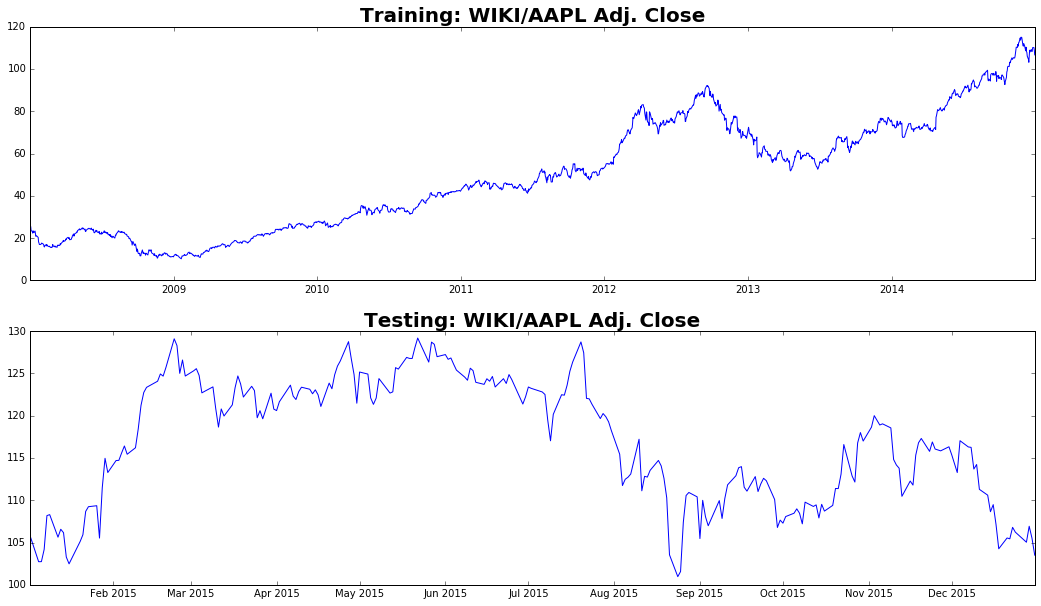

In [5]:
###### EVENTS ######
def on_button_clicked(b):
    clear_output()
    global trainingData
    global testingData
    global fig
    global ax
    global ax2
    # Get user input values from search parameters textboxes.
    # Training search parameters.
    trainingTickerName = trainingTickerName_textbox.value
    trainingTickerStart = trainingTickerStart_textbox.value
    trainingTickerEnd = trainingTickerEnd_textbox.value
    # Testing search parameters.
    testingTickerName = testingTickerName_textbox.value
    testingTickerStart = testingTickerStart_textbox.value
    testingTickerEnd = testingTickerEnd_textbox.value
    # Feature search parameter.
    feature = feature_textbox.value
    
    # Training data acquisition.
    trainingData_dataframe = quandl.get(trainingTickerName, start_date=trainingTickerStart, end_date=trainingTickerEnd)
    #trainingData = quandl.get(trainingTickerName, start_date=trainingTickerStart, end_date=trainingTickerEnd, returns="numpy")
    trainingData = trainingData_dataframe[feature]
    
    # Testing data acquisition.
    testingData_dataframe = quandl.get(testingTickerName, start_date=testingTickerStart, end_date=testingTickerEnd)
    #trainingData = quandl.get(trainingTickerName, start_date=trainingTickerStart, end_date=trainingTickerEnd, returns="numpy")
    testingData = testingData_dataframe[feature]
    
    # Create figure for plotting.
    fig = plt.figure(figsize=(18,10))
    # Plot training data.
    ax = fig.add_subplot(2, 1, 1)
    ax.plot(trainingData)
    ax.set_title("Training: " + trainingTickerName + " " + feature, fontsize = '20', weight = 'bold')
    # Plot testing data.
    ax2 = fig.add_subplot(2, 1, 2)
    ax2.set_title("Testing: " + testingTickerName + " " + feature, fontsize = '20', weight = 'bold')
    ax2.plot(testingData)
    
###### END EVENTS ######

###### CONTROLS ######
### TEXTBOX ###
# Define a new textbox for the training ticker name.
trainingTickerName_textbox = widgets.Text()
trainingTickerName_textbox.width = '10%'
# Define a new textbox for the training ticker start date.
trainingTickerStart_textbox = widgets.Text()
trainingTickerStart_textbox.width = '10%'
# Define a new textbox for the training ticker end date.
trainingTickerEnd_textbox = widgets.Text()
trainingTickerEnd_textbox.width = '10%'
# Define a new textbox for the testing ticker name.
testingTickerName_textbox = widgets.Text()
testingTickerName_textbox.width = '10%'
# Define a new textbox for the testing ticker start date.
testingTickerStart_textbox = widgets.Text()
testingTickerStart_textbox.width = '10%'
# Define a new textbox for the testing ticker end date.
testingTickerEnd_textbox = widgets.Text()
testingTickerEnd_textbox.width = '10%'
# Define a new textbox for time series to use.
feature_textbox = widgets.Text()
feature_textbox.width = '15%'
### END TEXTBOX ###

### BUTTON ###
# Create a button.
button = widgets.Button(description="Get data")
# Define event.
button.on_click(on_button_clicked)
### END BUTTON ###

### DISPLAY ###
# Show the training ticker textboxes as an horizontal display.
display(widgets.HBox((widgets.Label("Enter ticker for training: "),trainingTickerName_textbox, widgets.Label("Start: "), 
                      trainingTickerStart_textbox, widgets.Label("End: "), trainingTickerEnd_textbox)))
# Show the testing ticker textboxes as an horizontal display.
display(widgets.HBox((widgets.Label("Enter ticker for testing: "),testingTickerName_textbox, widgets.Label("Start: "),
                      testingTickerStart_textbox, widgets.Label("End: "), testingTickerEnd_textbox)))
# Show feature textboxes and button as an horizontal display.
display(widgets.HBox((button, widgets.Label("Use: "),feature_textbox)))
### END DISPLAY ###
###### END CONTROLS ######

###### VARIABLES INITIALIZATION ######
# Initialize the data for storing search parameters.
# Training search parameters. 
trainingTickerName = ""
trainingTickerStart = ""
trainingTickerEnd = ""
# Testing search parameters.
testingTickerName = ""
testingTickerStart = ""
testingTickerEnd = ""
# Training data acquired.
trainingData = []
# Testing data acquired.
testingData = []

# Initialize texboxes.
# Training search textboxes. 
trainingTickerName_textbox.value = "WIKI/AAPL"
trainingTickerStart_textbox.value = "2008-01-01"
trainingTickerEnd_textbox.value = "2014-12-31"
# Testing search textboxes.
testingTickerName_textbox.value = "WIKI/AAPL"
testingTickerStart_textbox.value = "2015-01-01"
testingTickerEnd_textbox.value = "2016-01-01"
# Feature textbox.
feature_textbox.value = "Adj. Close"

###### END VARIABLES INITIALIZATION
#fig = plt.figure(figsize=(18,10))
#ax = fig.add_subplot(2, 1, 1)
#ax2 = fig.add_subplot(2, 1, 2)



## Policy training
In this section the parameters may be varied in order to fit the policy to the data, in the search of an optimal policy. The parameters to be varied may be:
* M - Neuron inputs window.
* T - Training window.
* initialTheta - The initial value for the theta vector.
* optimizationFunction - Sharpe or profit

3.45820240267


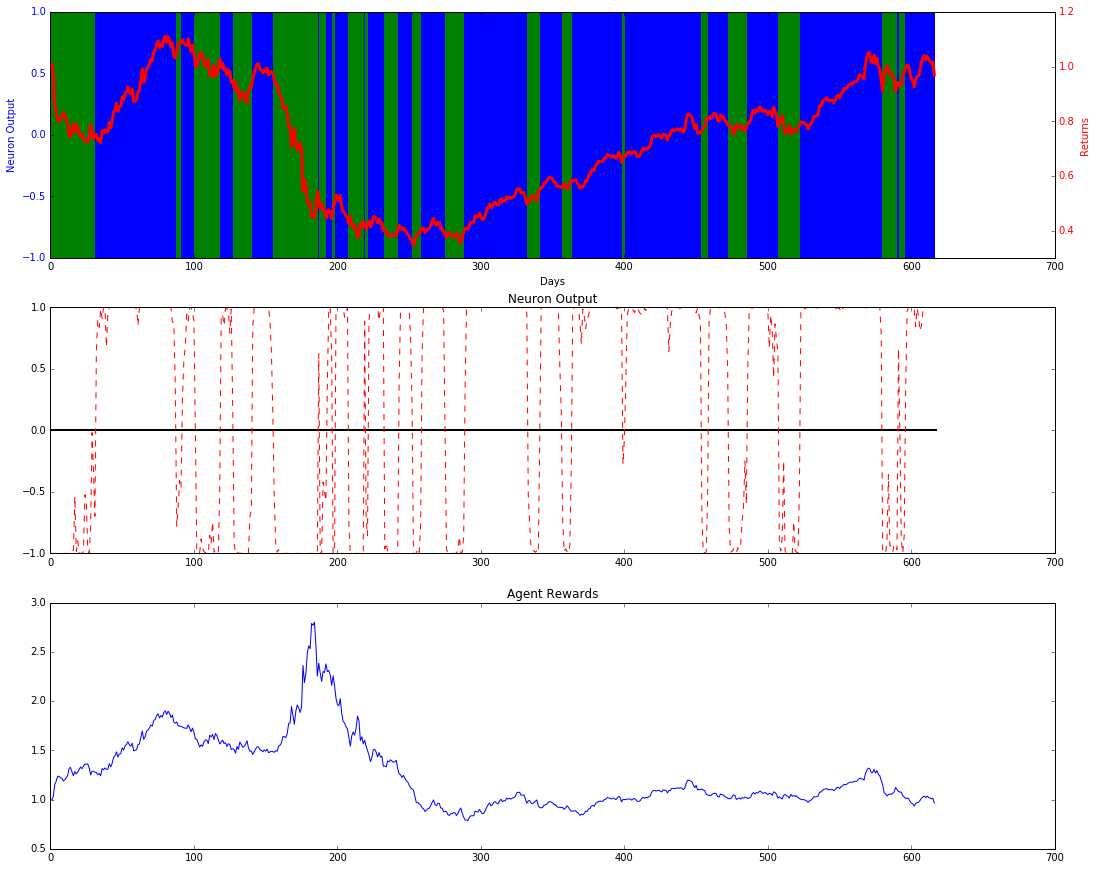

In [14]:
###### VARIABLES INITIALIZATION ######
theta = []
###### END VARIABLES INITIALIZATION ######

###### EVENTS ######
def fit(M, T, optimizationFunction, initialTheta, transactionCosts, mu, rho):
    global theta
    # Set the parameters
    startPos = M
    finishPos = startPos + T
    F = np.zeros(T + 1)
    dF = np.zeros(T + 1)
    
    # Generate the returns.
    X = uf.GetReturns(trainingData)
    Xn = uf.FeatureNormalize(X)
    
    # Initialize theta
    theta = np.ones(M+2)*initialTheta
    
    # Compute optimal theta value.
    #theta = fmin_ncg(cf.ObjectiveFunction, theta, cf.GradientFunctionM, args=(X, Xn, T, M, mu, transactionCosts, startPos, optimizationFunction), avextol=1e-8, maxiter=50)
    theta = cf.train(theta, X, Xn, T, M, mu, transactionCosts, startPos, rho, 500, optimizationFunction)
    
    # Compute the neuron output.
    F = cf.ComputeF(theta, Xn, T, M, startPos)
    
    # Compute the rewards
    rewards = cf.RewardFunction(mu, F, transactionCosts, T, M, X)
    
    # Compute the cumulative reward.
    rewards = rewards + 1 # Add one to the rewards vector such that the reward does not vanish.
    for i in range(1, rewards.size):
        rewards[i] = rewards[i-1]*rewards[i]
    
    # Compute the cummulative returns.
    returns = X[startPos:finishPos] + 1
    for i in range(1, returns.size):
        returns[i] = returns[i-1]*returns[i]
    
    # Create figure for plotting.
    fig = plt.figure(figsize=(18,15))
    ## Plot rewards and policy decisions.
    ax1a = fig.add_subplot(3, 1, 1)
    ### Plot neuron output
    t = np.arange(0.0, 150.0, 1)
    ax1a.plot(F[1:], 'y')
    ax1a.set_xlabel('Days')
    ax1a.set_ylabel('Neuron Output', color='b')
    for tl in ax1a.get_yticklabels():
        tl.set_color('b')
    ### Plot the policy output.
    B = F[1:] > 0
    for i,b in enumerate(B):
        if b:
            plt.plot([i, i], [-1, 1], color='b', linestyle='-', linewidth=2)
        else:
            plt.plot([i, i], [-1, 1], color='g', linestyle='-', linewidth=2)
    ### Plot returns.
    ax1b = ax1a.twinx()
    ax1b.plot(returns, 'r-', linewidth=3)
    ax1b.set_ylabel('Returns', color='r')
    for tl in ax1b.get_yticklabels():
        tl.set_color('r')
        
    ### Plot Neuron output.
    ax2 = fig.add_subplot(3, 1, 2)
    ax2.set_title("Neuron Output")
    ax2.plot([0, T], [0, 0], color='k', linestyle='-', linewidth=2)
    ax2.plot(F[1:], color='r', linestyle='--')

    ### Plot agent rewards.
    ax3 = fig.add_subplot(3, 1, 3)
    ax3.set_title("Agent Rewards")
    ax3.plot(rewards)
    
    print (cf.SharpeRatio(rewards[0:i]))
    
###### END EVENTS ######

###### CONTROLS ######
interact(fit, M=widgets.IntSlider(min=0,max=200,step=1,value=10), T=widgets.IntSlider(min=0,max=1000,step=1,value=100),
        optimizationFunction = ["return","sharpeRatio"], initialTheta = 1, 
         transactionCosts = widgets.FloatSlider(min=0,max=0.1,step=0.001,value=0.001), mu = 1,
        rho = widgets.FloatSlider(min=0,max=1,step=0.1, value=1))
###### END CONTROLS ######

## Training
Next the system is trained using the following process:
* Use the optimal policy (obtained in the previous cell) to make predictions from t = T+1 to t = t + N

Training ...
On iteration:  1
On iteration:  2
On iteration:  3
On iteration:  4
On iteration:  5
On iteration:  6
On iteration:  7
On iteration:  8
On iteration:  9
On iteration:  10
On iteration:  11
On iteration:  12
On iteration:  13
On iteration:  14
Finished trainng.


<function __main__.fit>

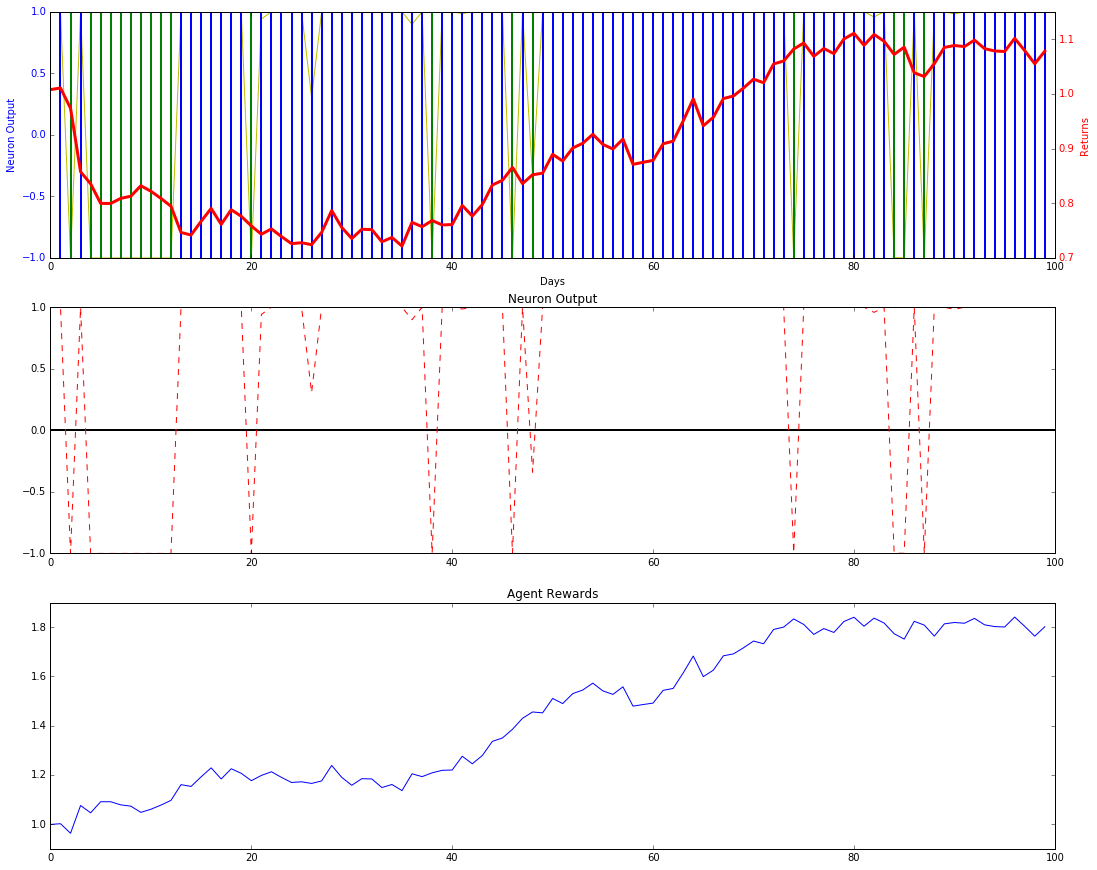

In [15]:
theta = []
###### EVENTS ######
def fit(M, T, optimizationFunction, initialTheta, transactionCosts, mu):
    global theta
    # Set the parameters
    startPos = M
    finishPos = startPos + T
    F = np.zeros(T + 1)
    dF = np.zeros(T + 1)
    
    # Generate the returns.
    X = uf.GetReturns(trainingData)
    Xn = uf.FeatureNormalize(X)
    
    # Initialize theta
    theta = np.ones(M+2)*initialTheta
    
    # Compute optimal theta value.
    startPos += T
    I = 15

    print("Training ...")
    for i in range(1, I):
        print("On iteration: ", i)
        #theta = fmin_ncg(cf.ObjectiveFunction, theta, cf.GradientFunctionM, 
        #                  args=(X, Xn, T, M, mu, transactionCosts, startPos, optimizationFunction), 
        #                  avextol=1e-8, maxiter=50)

        theta = cf.train(theta, X, Xn, T, M, mu, transactionCosts, startPos, 1, 500, optimizationFunction)
        startPos += T
    print("Finished trainng.")
    startPos = M
    
    # Compute the neuron output.
    F = cf.ComputeF(theta, Xn, T, M, startPos)
    
    # Compute the rewards
    rewards = cf.RewardFunction(mu, F, transactionCosts, T, M, X)
    
    # Compute the cumulative reward.
    rewards = rewards + 1 # Add one to the rewards vector such that the reward does not vanish.
    for i in range(1, rewards.size):
        rewards[i] = rewards[i-1]*rewards[i]
    
    # Get the cummulative returns.
    returns = X[startPos:finishPos] + 1
    for i in range(1, returns.size):
        returns[i] = returns[i-1]*returns[i]
    
    # Create figure for plotting.
    fig = plt.figure(figsize=(18,15))
    # Plot rewards and policy decisions.
    ax1a = fig.add_subplot(3, 1, 1)
    ## Plot neuron output
    t = np.arange(0.0, 150.0, 1)
    ax1a.plot(F[1:], 'y')
    ax1a.set_xlabel('Days')
    ax1a.set_ylabel('Neuron Output', color='b')
    for tl in ax1a.get_yticklabels():
        tl.set_color('b')
    ## Plot the policy output.
    B = F[1:] > 0
    for i,b in enumerate(B):
        if b:
            plt.plot([i, i], [-1, 1], color='b', linestyle='-', linewidth=2)
        else:
            plt.plot([i, i], [-1, 1], color='g', linestyle='-', linewidth=2)
    ## Plot returns.
    ax1b = ax1a.twinx()
    ax1b.plot(returns, 'r-', linewidth=3)
    ax1b.set_ylabel('Returns', color='r')
    for tl in ax1b.get_yticklabels():
        tl.set_color('r')
        
    # Plot Neuron output.
    ax2 = fig.add_subplot(3, 1, 2)
    ax2.set_title("Neuron Output")
    ax2.plot([0, T], [0, 0], color='k', linestyle='-', linewidth=2)
    ax2.plot(F[1:], color='r', linestyle='--')
    #ax2.ylim([-1,1])
    #ax2.xlim([0, finishPos])
    # Plot agent rewards.
    ax3 = fig.add_subplot(3, 1, 3)
    ax3.set_title("Agent Rewards")
    ax3.plot(rewards)
    #ax3.xlim([0, finishPos])
    
###### END EVENTS ######

###### CONTROLS ######
interact(fit, M=widgets.IntSlider(min=0,max=200,step=1,value=10), T=widgets.IntSlider(min=0,max=1000,step=1,value=100),
        optimizationFunction = ["return","sharpeRatio"], initialTheta = 1, 
         transactionCosts = widgets.FloatSlider(min=0,max=0.1,step=0.001,value=0.001), mu = 1)
###### END CONTROLS ######

###### VARIABLES INITIALIZATION ######

###### END VARIABLES INITIALIZATION ######

## Testing


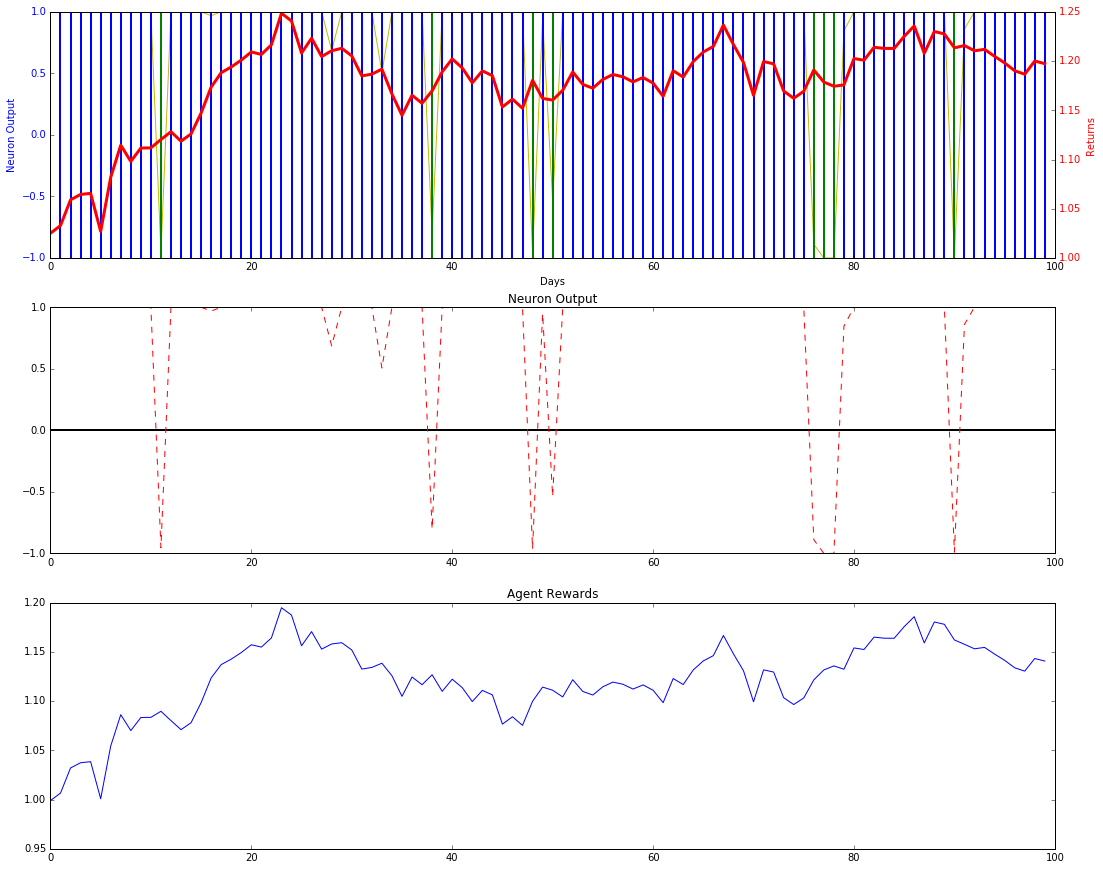

In [17]:
# Generate the returns.
X = uf.GetReturns(testingData)
Xn = uf.FeatureNormalize(X)

T = 100
M = 10
mu = 1
transactionCosts = 0.001
startPos = M
finishPos = startPos + T

# Compute the neuron output.
F = cf.ComputeF(theta, Xn, T, M, startPos)
    
# Compute the rewards
rewards = cf.RewardFunction(mu, F, transactionCosts, T, M, X)
    
# Compute the cumulative reward.
rewards = rewards + 1 # Add one to the rewards vector such that the reward does not vanish.
for i in range(1, rewards.size):
    rewards[i] = rewards[i-1]*rewards[i]
    
# Get the cummulative returns.
returns = X[startPos:finishPos] + 1
for i in range(1, returns.size):
    returns[i] = returns[i-1]*returns[i]
    
# Create figure for plotting.
fig = plt.figure(figsize=(18,15))
# Plot rewards and policy decisions.
ax1a = fig.add_subplot(3, 1, 1)
## Plot neuron output
t = np.arange(0.0, 150.0, 1)
ax1a.plot(F[1:], 'y')
ax1a.set_xlabel('Days')
ax1a.set_ylabel('Neuron Output', color='b')
for tl in ax1a.get_yticklabels():
    tl.set_color('b')
## Plot the policy output.
B = F[1:] > 0
for i,b in enumerate(B):
    if b:
        plt.plot([i, i], [-1, 1], color='b', linestyle='-', linewidth=2)
    else:
        plt.plot([i, i], [-1, 1], color='g', linestyle='-', linewidth=2)
## Plot returns.
ax1b = ax1a.twinx()
ax1b.plot(returns, 'r-', linewidth=3)
ax1b.set_ylabel('Returns', color='r')
for tl in ax1b.get_yticklabels():
    tl.set_color('r')
        
# Plot Neuron output.
ax2 = fig.add_subplot(3, 1, 2)
ax2.set_title("Neuron Output")
ax2.plot([0, T], [0, 0], color='k', linestyle='-', linewidth=2)
ax2.plot(F[1:], color='r', linestyle='--')
#ax2.ylim([-1,1])
#ax2.xlim([0, finishPos])
# Plot agent rewards.
ax3 = fig.add_subplot(3, 1, 3)
ax3.set_title("Agent Rewards")
ax3.plot(rewards)
#ax3.xlim([0, finishPos])

In [ ]:
theta